# ライブラリのインポート

In [2]:
import numpy as np
from numpy import linalg as LA
import pandas as pd; pd.set_option('display.max_columns', None)

import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()
%precision 3

# utility
import sys
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import pickle
import openpyxl as px
import xlrd
from functools import reduce

# 乱数
rng = np.random.RandomState(1234)
random_state = 42


# ローカルライブラリ
%cd /users/keimy/notebooks/OCT_hitachi
import src.archetypes as arch



/Users/keimy/notebooks/OCT_hitachi


In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# scikit-learn
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multioutput import MultiOutputClassifier

# 様々なモデル
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# 次元削減
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from sklearn.decomposition import PCA

# データ取得

In [3]:
def make_datasets_per_ROI(ROI):
    df = pd.DataFrame()
    first_loop = True
    for data in [f"{ROI}2016"]:
        tmp = pd.read_csv(f"../data_oct/{data}.csv")
        tmp = tmp.rename(columns={"r1l2": "eye", "RL": "eye"})

        if first_loop: 
            df = tmp
            first_loop = False
        else: 
            df = pd.concat([df, tmp])

    # Variable transformation and missing value deletion
    df = df.rename(columns={"TopQImageQuality": "QS", "kenshinID": "ID"})
    df = df.dropna(subset=["cpRNFL_T"]) if ROI == "cpRNFL" else df.dropna(subset=[f"{ROI}_01_01"])

    # Zero-padding for the central part of mRNFL, mGCLP
    if ROI not in ["retina", "cpRNFL"]:
        for coord in ["05_05", "05_06", "06_05", "06_06"]:
            df[f"{ROI}_{coord}"] = 0

    # Sample size, shuffle rows, and remove duplicate IDs
    df = df.sample(frac=1, random_state=0).drop_duplicates(subset=["ID"])

    # Calculate overall average
    n = len(df)
    shape = (1, 12) if ROI == "cpRNFL" else (10, 10)
    total = np.full(shape, 0)
    for i in range(n):
        OCT_per_patient = df.iloc[i, 3:15] if ROI == "cpRNFL" else df.iloc[i, 3:103]
        total += np.array(OCT_per_patient).astype("int64").reshape(shape)

    sq_mu = total // n
    vec_mu = sq_mu.reshape(1, 12) if ROI == "cpRNFL" else sq_mu.reshape(1, 100)

    # Concatenate all OCT arrays (vertical vector) into data matrix X
    shape = (0, 12) if ROI == "cpRNFL" else (0, 100)
    X = np.full(shape, 0)
    thicks = [0] * n

    for i in tqdm(range(n)):
        OCT_per_patient = df.iloc[i, 3:15] if ROI == "cpRNFL" else df.iloc[i, 3:103]
        OCT_per_patient = np.array(OCT_per_patient)
        thick = np.mean(OCT_per_patient)
        thicks[i] = thick

        shape = (1, 12) if ROI == "cpRNFL" else (1, 100)
        new_data = OCT_per_patient.reshape(shape).astype(np.int64)
        X = np.concatenate((X, new_data), axis=0)

    df[f"thick_{ROI}"] = thicks
    df = df.reset_index(drop=True)

    return df, X


data_cpRNFL = make_datasets_per_ROI("cpRNFL")
data_mRNFL = make_datasets_per_ROI("mRNFL")
data_mGCLP = make_datasets_per_ROI("mGCLP")

df_cpRNFL, X_cpRNFL = data_cpRNFL[0], data_cpRNFL[1]
df_mRNFL, X_mRNFL = data_mRNFL[0], data_mRNFL[1]
df_mGCLP, X_mGCLP = data_mGCLP[0], data_mGCLP[1]

dfs = [df_cpRNFL, df_mRNFL, df_mGCLP]
df = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs)
X = np.concatenate((X_cpRNFL, X_mRNFL, X_mGCLP), axis=1)

100%|██████████| 7666/7666 [00:02<00:00, 2752.83it/s]


# 学習（アーキタイプ分析）

In [ ]:
# アーキタイプの計算：k=3で20s, K=5で90s, K=7で150s, K=10で190s, K=14で210s, K=18で330s
# テンプレ：model = arch.AA(n_archetypes=5, n_init=10, max_iter=10_000, tol=1e-16, random_state=0, verbose=False)

max_k = 12
Zs = [None]*(max_k+1)
ATs = [None]*(max_k+1)
RSSs = [None]*(max_k+1)

for i in tqdm(range(1,max_k+1)):
    model = arch.AA(n_archetypes = i, random_state = 0, verbose = True)
    model.fit(X)

    Zs[i] = model.fit_transform(X)
    ATs[i] = model.archetypes_
    RSSs[i] = model.rss_

# K=1から15までのZ, ATなどのパラメーターをすべて保存
with open(f'../params/Zs.pickle', mode='wb') as f: pickle.dump(Zs, f)
with open(f'../params/ATs.pickle', mode='wb') as f: pickle.dump(ATs, f)
with open(f'../params/RSSs.pickle', mode='wb') as f: pickle.dump(RSSs, f)


### 途中から追加する場合

In [ ]:
import pickle

# 既存のデータを読み込む
with open('../params/Zs.pickle', mode='rb') as f: Zs = pickle.load(f)
with open('../params/ATs.pickle', mode='rb') as f: ATs = pickle.load(f)
with open('../params/RSSs.pickle', mode='rb') as f: RSSs = pickle.load(f)

# リストのサイズを新たな最大Kに合わせて拡張

restart_k = len(Zs)
max_k = 15
Zs.extend([None] * (max_k + 1 - len(Zs)))
ATs.extend([None] * (max_k + 1 - len(ATs)))
RSSs.extend([None] * (max_k + 1 - len(RSSs)))

for i in tqdm(range(restart_k, max_k + 1)):
    model = arch.AA(n_archetypes=i, random_state=0, verbose=True)
    model.fit(X)

    Zs[i] = model.fit_transform(X)
    ATs[i] = model.archetypes_
    RSSs[i] = model.rss_

# 更新されたデータを保存
with open('../params/Zs.pickle', mode='wb') as f: pickle.dump(Zs, f)
with open('../params/ATs.pickle', mode='wb') as f: pickle.dump(ATs, f)
with open('../params/RSSs.pickle', mode='wb') as f: pickle.dump(RSSs, f)


# 学習すみモデルの読み込み

### RSSの推移をプロットする

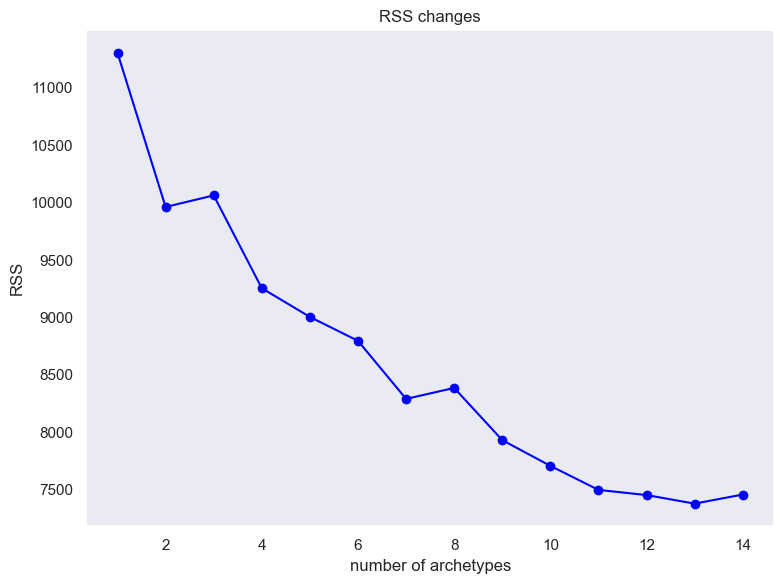

In [3]:

with open(f'../params/RSSs.pickle', mode='br') as f: RSSs2 = pickle.load(f)

# グラフをプロット
plt.figure(figsize=(8, 6))
plt.plot(RSSs2[:-1], color='blue', linestyle='-', marker='o')

# タイトルと軸のラベルを設定 (必要に応じて編集してください)
plt.title(f"RSS changes")
plt.xlabel("number of archetypes")
plt.ylabel("RSS")

# グリッド線を非表示にする
plt.grid(False)

# 余白を調整
plt.tight_layout()

# グラフを表示
plt.savefig(f"../figures/RSS.png", dpi = 300)


In [48]:
# パラメーターの読み込み　念のため読み込み名を変更しておく
with open(f'../params/Zs.pickle', mode='br') as f: Zs2 = pickle.load(f)
with open(f'../params/ATs.pickle', mode='br') as f: ATs2 = pickle.load(f)

# Kを指定
k = 9
Z = Zs2[k]
AT = ATs2[k]

# OCTデータにそれぞれのAT割合を追加して、新しいCSVに保存
# for i in range(k): OCT[f"AT{i+1}"] = Z[:, i]
# OCT.to_csv(f"../data_oct/{ROI}_K{k}.csv", index = False)

# 行列サイズがあってるか確認
# X.shape, Z.shape, AT.shape

### Figureをマッピングする関数

In [49]:
# Figureを作成する関数

def plot_cpRNFL(arr, ax):
    # cpRNFLの描写
    vmin, vmax = (40, 60)
    angles = np.linspace(0, 360, 13)[:-1]
    normed_values = (arr - vmin) / (vmax - vmin)
    normed_values = np.clip(normed_values, 0, 1)
    normed_values = np.roll(normed_values[::-1], shift=-5)
    colors = plt.cm.RdYlGn(normed_values)
    bars = ax.bar(angles * np.pi / 180, [1]*12, bottom=0, width=np.pi / 6, color=colors)

    ax.set_rorigin(0)  # ここを修正
    ax.set_yticklabels([])  # 半径のラベルを非表示に
    ax.set_xticklabels([])  # 角度のラベルを非表示に

    # S, N, I, Tのラベルを追加
    offset = 0.05
    ax.text(0-offset, 0.5, 'T', ha='center', va='center', transform=ax.transAxes)
    ax.text(1+offset, 0.5, 'N', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 0-offset, 'I', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 1+offset, 'S', ha='center', va='center', transform=ax.transAxes)

    # 数字のテキストを図示
    radius, offset = (0.3, 0.5)
    arr = np.roll(arr[::-1], shift = -2)
    for bar, value in zip(bars, arr):
        angle = (bar.get_x() + bar.get_width() / 2) * 180 / np.pi - 90
        x = np.cos(np.deg2rad(angle)) * radius + offset
        y = np.sin(np.deg2rad(angle)) * radius + offset
        plt.text(x, y, str(value), ha='center', va='center', transform=ax.transAxes)

def plot_other_ROI(arr, ax, ROI):
    # mRNFLやmGCLPの描写　デフォルトでは(10, 110)
    vmin, vmax = (210, 330) if ROI == "retina" else (10, 110)
    sns.heatmap(arr, annot=True, cmap='RdYlGn', fmt="d", vmin=vmin, vmax=vmax, ax=ax)

### K個のアーキタイプを可視化

In [50]:
for i in range(k):
    octmap = AT[i]
    # AT_mapをcpRNFL, mRNFL, mGCLPの部分に分割
    cpRNFL_data = np.array(octmap[:12]).astype("int64")
    mRNFL_data = np.array(octmap[12:112]).astype("int64").reshape((10, 10))
    mGCLP_data = np.array(octmap[112:]).astype("int64").reshape((10, 10))

    # 1つの図（figure）に3つのプロットを配置
    fig = plt.figure(figsize=(15, 5))


    # mGCLPのプロット
    ax1 = fig.add_subplot(131)
    plot_other_ROI(mGCLP_data, ax1, "mGCLP")

    # mRNFLのプロット
    ax2 = fig.add_subplot(132)
    plot_other_ROI(mRNFL_data, ax2, "mRNFL")

    # cpRNFLのプロット（極座標）
    ax3 = fig.add_subplot(133, polar=True)
    plot_cpRNFL(cpRNFL_data, ax3)

    # 図全体のタイトルを設定
    fig.suptitle(f"Archetype {i+1} across ROIs")
    plt.tight_layout()

    # 画像の保存
    fig.savefig(f"../figures/AT_K{k}/AT_{i+1}.png")
    plt.close(fig)

In [ ]:
# 実際のOCT画像についてアーキタイプ分解

for i in range(5):
    octmap = X[i]
    # AT_mapをcpRNFL, mRNFL, mGCLPの部分に分割
    cpRNFL_data = np.array(octmap[:12]).astype("int64")
    mRNFL_data = np.array(octmap[12:112]).astype("int64").reshape((10, 10))
    mGCLP_data = np.array(octmap[112:]).astype("int64").reshape((10, 10))

    # 1つの図（figure）に3つのプロットを配置
    fig = plt.figure(figsize=(15, 5))

    # mGCLPのプロット
    ax1 = fig.add_subplot(131)
    plot_other_ROI(mGCLP_data, ax1, "mGCLP")

    # mRNFLのプロット
    ax2 = fig.add_subplot(132)
    plot_other_ROI(mRNFL_data, ax2, "mRNFL")

    # cpRNFLのプロット（極座標）
    ax3 = fig.add_subplot(133, polar=True)
    plot_cpRNFL(cpRNFL_data, ax3)
    

    # 図全体のタイトルを設定
    title = ""
    for j in range(k):
        effect = (Z[i][j]*100).round(1)
        if j < 4: title += f"AT{j+1} = {effect}   "
        elif j == 4: title += f"AT{j+1} = {effect}   \n"
        elif j > 4: title += f"AT{j+1} = {effect}   "
    fig.suptitle(f"OCT_sample_{i+1} \n {title}")
    plt.tight_layout()


    fig.savefig(f"../figures/OCT_K{k}/data_{i+1}.png")
    plt.close(fig)



# 完全データセットの作成

### OCT_AT_comb

In [4]:
# パラメーターの読み込み　念のため読み込み名を変更しておく
with open(f'../params/Zs.pickle', mode='br') as f: Zs2 = pickle.load(f)
with open(f'../params/ATs.pickle', mode='br') as f: ATs2 = pickle.load(f)


for k in range(8, 13):
    Z = Zs2[k]
    AT = ATs2[k]

    # Zをデータフレーム化して、cATを作成（カットオフは1%以上）
    Z_df = pd.DataFrame(Z, columns=[f'AT{i}' for i in range(1, k+1)])
    for i in range(1, k+1): Z_df[f'cAT{i}'] = (Z_df[f'AT{i}'] > 0.01).astype(int)

    # OCTとZ_dfを横に結合
    OCT_AT_comb = pd.concat([df, Z_df], axis=1)
    OCT_AT_comb.to_csv(f"../outputs/OCT_AT_comb_K{k}.csv", index = False)


### OCT_AT_kenshin_comb ; N=(7666, 17026)

In [5]:
def conversion_to_int(df, filling):
    df2 = pd.to_numeric(df, errors='coerce')
    df2.fillna(1, inplace=True)  # 例: 0で置換
    df2 = df2.astype(np.int64)
    return df2


for k in range(8, 13):
    OCT = pd.read_csv(f"../outputs/OCT_AT_comb_K{k}.csv")

    kenshin = pd.read_csv("../data_kenshin/2016R2.csv"); kenshin.drop(index=0, inplace=True)
    kenshin = kenshin.rename(columns={"kenshinID": "ID" })
    kenshin = kenshin.reset_index(drop=True)

    # マージの準備
    OCT['ID'] = OCT['ID'].astype(str)
    kenshin['ID'] = kenshin['ID'].astype(str)
    OCT['date'] = pd.to_datetime(OCT['topID'].astype(str).str[-8:])
    kenshin['date'] = pd.to_datetime(kenshin['kenshindate'].astype(str))

    # IDとdateを使ってOCTとkenshinをマージ
    df_merged = pd.merge(OCT, kenshin, on=['ID', 'date'], how='inner')

    # 問診項目の変数処理
    df_merged["smoking"] = (conversion_to_int(df_merged["mon3x1x1"], 1) != 1).astype(int)
    df_merged["drinking"] = (conversion_to_int(df_merged["mon3x2x1"], 0) != 0).astype(int)
    df_merged["exercise"] = (conversion_to_int(df_merged["mon5x4x1"], 1) != 1).astype(int)
    df_merged["sleep"] = conversion_to_int(df_merged["mon2x2"], 9)
    df_merged["short_sleep_6"] = ((df_merged.sleep == 1) | (df_merged.sleep == 2)).astype(int)
    df_merged["short_sleep_5"] = (df_merged.sleep == 1).astype(int)

    # csvに出力
    df_merged.to_csv(f"../outputs/OCT_AT_kenshin_comb_K{k}.csv", index = False)



/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_90624/517110768.py:11: DtypeWarning: Columns (86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,106,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,130,133,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,187,188,189,190,191,192,193,194,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  kenshin = pd.read_csv("../data_kenshin/2016R2.csv"); kenshin.drop(index=0, inplace=True)
/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_90624/517110768.py:11: DtypeWarning: Columns (86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,106,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,130,133,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,

# メイン解析

In [13]:
k = 12
df = pd.read_csv(f"../outputs/OCT_AT_kenshin_comb_K{k}.csv")

vars_1 = [
    'height', 'weight', 'BMI', 'waist', 'bfat','sbp', 'dbp', 'WBC', 'RBC',
    'HB', 'HT', 'MCV', 'MCH', 'MCHC', 'PLT', 'FBS0', 'HBA1C', 'TC', 'TG', 'HDLC',
    'LDL', 'AST', 'ALT', 'GGT', 'LD', 'ALP', 'TBIL', 'TP', 'ALB', 'UA', 'AMY',
    'BUN', 'CRE', 'NA', 'K', 'EGFR', 'CRP', 'CPK'
]

vars_2 = [
    'smoking', 'drinking', 'exercise', 'short_sleep_6', 'short_sleep_5'
]


# 連続変数を中央値で区切ってバイナリーに
# for var in vars_1:
#     median_value = df[var].median()
#     df[f'{var}_c'] = (df[var] > median_value).astype(int)
# vars_1 = [f'{var}_c' for var in vars_1]



vars = vars_1 + vars_2


/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_91953/2481187805.py:2: DtypeWarning: Columns (540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,560,564,565,566,567,568,569,570,571,572,573,574,575,576,577,579,580,581,584,587,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,641,642,643,644,645,646,647,648,653,654) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../outputs/OCT_AT_kenshin_comb_K{k}.csv")


### ロジスティック

In [14]:
# ロジスティック回帰を実行し、特定の変数のオッズ比のみを計算する関数
def logistic_regression_for_specific_vars(data, target_vars, domain_vars):
    results = []
    for target_var in target_vars:
        for domain_var in domain_vars:
            # ATモデル
            # formula_at = f'{target_var} ~ {domain_var} + thick_mRNFL + thick_mGCLP + thick_cpRNFL + age + sex'
            formula_at = f'{target_var} ~ {domain_var} + age + sex'

            model_at = smf.logit(formula_at, data=data).fit()
            or_at = np.exp(model_at.params)[domain_var]  # domain_var のオッズ比のみ抽出
            ci_at = np.exp(model_at.conf_int()).loc[domain_var]  # domain_var の信頼区間のみ抽出
            p_value_at = model_at.pvalues[domain_var]  # domain_var のp値のみ抽出
            results.append({
                'Target': target_var,
                'Variable': domain_var,
                'OR': or_at,
                'OR_lower': ci_at[0],
                'OR_upper': ci_at[1],
                'p_value': p_value_at
            })


    return pd.DataFrame(results)

target_vars = [f"cAT{i}" for i in range(1,k+1)]

# 全ての組み合わせに対してロジスティック回帰を実行
res = logistic_regression_for_specific_vars(df, target_vars, vars)

csv_file_path = f'../results/ORs_K{k}.csv'
res.to_csv(csv_file_path, index=False)


Optimization terminated successfully.
         Current function value: 0.682944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682905
  

### マンホイットニーとカイ二乗検定

In [61]:
from scipy.stats import mannwhitneyu, chi2_contingency

# マンホイットニーU検定
results_mannwhitney = []
for i in range(1, k+1):
    for var in vars:
        # グループごとの平均値を計算
        group_means = df.groupby(f'{var}')[f'AT{i}'].mean()
        groups = df.groupby(f'{var}')[f'AT{i}']

        if len(groups) == 2:  # 2つのグループが必要
            stat, p = mannwhitneyu(*[group for name, group in groups])
            results_mannwhitney.append({
                "AT": f"AT{i}",
                "variables": var,
                # "統計量": stat,
                "p_values": p,
                "means_by_groups": group_means.to_dict()
            })

results_df_mannwhitney = pd.DataFrame(results_mannwhitney)
results_df_mannwhitney.to_csv(f"../results/utest_K{k}.csv", index=True)


# カイ二乗検定
results_chi2 = []
for i in range(1, k+1):
    for var in vars:
        # 含有割合を計算
        total_counts = df[f'cAT{i}'].value_counts()
        group_counts = df.groupby(f'{var}')[f'cAT{i}'].value_counts(normalize=True)

        table = pd.crosstab(df[f'{var}'], df[f'cAT{i}'])
        chi2, p, dof, ex = chi2_contingency(table)
        results_chi2.append({
            "cAT": f"cAT{i}",
            "variables": var,
            # "χ2値": chi2,
            "p_values": p,
            # "自由度": dof,
            "ratios_by_groups": group_counts.to_dict()
        })

results_df_chi2 = pd.DataFrame(results_chi2)
results_df_chi2.to_csv(f"../results/chitest_K{k}.csv", index=True)



# OCTデータ＋MSPデータ

In [ ]:
ROI = "mGCLP"
k = 10

# OCTデータを再度読み込み
OCT = pd.read_csv(f"../data_oct/{ROI}_K{k}.csv")

# cAT(0 or 1)の処理
for i in range(1,k+1): OCT[f"cAT{i}"] = (OCT[f"AT{i}"] > 0).astype(np.int64)

len(OCT)

In [ ]:
MSP = pd.read_csv("../data_kenshin/MSP.csv")
MSP = MSP.rename(columns={"kenshinID": "ID" })
MSP = MSP.reset_index(drop=True)

# 若いIDを残す（昇順ソートで最初残し）
MSP = MSP.sort_values("date", ascending=1)
MSP1 = MSP.drop_duplicates(subset="ID")

# 最終IDを残す（降順ソートで最初残し）
MSP = MSP.sort_values("date", ascending=0)
MSP2 = MSP.drop_duplicates(subset="ID")

# 両方ともID順になおしておく
MSP1 = MSP1.sort_values("ID", ascending=1)
MSP2 = MSP2.sort_values("ID", ascending=1)

# インデックスを付与
MSP1 = MSP1.reset_index(drop=True)
MSP2 = MSP2.reset_index(drop=True)

len(MSP1), len(MSP2)


In [ ]:
from datetime import datetime

n = len(MSP1)
flags = [0]*n
score_changes = [0]*n
follow = [0]*n

for i in range(n):
    score1,score2 = MSP1.loc[i, "msp"], MSP2.loc[i, "msp"]

    date1,date2 = MSP1.loc[i, "date"], MSP2.loc[i, "date"]
    date1 = datetime.strptime(date1, "%Y/%m/%d") # adjust the date format
    date2 = datetime.strptime(date2, "%Y/%m/%d") # adjust the date format
    date_diff = (date2 - date1).days
    follow[i] = date_diff
            
    if date_diff:
        score_change = np.mean(score2 - score1) * (365 / date_diff)
        score_changes[i] = score_change
    
    else: continue

MSP1["score_changes"] = score_changes
MSP1["follow_msp"] = follow

# 全体の数=4635, 縦断データの数=1405, score変化した数=203
len(MSP1), len(MSP1[MSP1.follow_msp > 0]), len(MSP1[MSP1.score_changes < 0])

In [ ]:
# OCTとMSP1(若いやつ)のマージ
df = pd.merge(OCT, MSP1, how = "inner", on = ["ID"])

# 日本語データを消して数字データに統一する
df['sex'] = df['sex'].map({'男性': 1, '女性': 0}).astype(int)
df['time'] = df['time'].str.replace('分', '').astype(int)

# MSPやOCT検査時点の年齢を計算
df['DOB'] = pd.to_datetime(df['DOB'])
df['msp_date'] = pd.to_datetime(df['date'])
df['oct_date'] = pd.to_datetime(df['topID'].astype(str).str[-8:], format='%Y%m%d')
df['age_msp'] = (df['msp_date'] - df['DOB']).dt.days // 365
df['age_oct'] = (df['oct_date'] - df['DOB']).dt.days // 365

# msp_modを作成：msp=15のとき正常0点とする。あくまで初期スコアで
# df["msp_mod"] = 15 - df["msp"]
df["msp_mod"] = (df["msp"] - df["msp"].mean()) / df["msp"].std(ddof=1)

# セルのRDB変数を全削除：ROIを含むカラムを検索
df = df.drop(columns=[col for col in df.columns if 'RDB' in col])

# SAS用に保存
df.to_csv(f"../outputs/{ROI}_K{k}.csv", index = False)

# 全体の数=1746, 縦断データの数=510, score変化した数=75
len(df), len(df[df.follow_msp > 0]), len(df[df.score_changes < 0])

# OCTデータ＋VDTデータ